In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
import matplotlib.pyplot as plt

# Load disease dataset

In [ ]:
disease_data = pd.read_csv('https://data.cdc.gov/resource/muzy-jte6.csv?$limit=50000')

# Scrape climate dataset

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver import Keys
from selenium.webdriver.common.action_chains import ActionChains
import pandas as pd
import numpy as np
from time import sleep




ModuleNotFoundError: ignored

In [ ]:
def index_to_state(idx):
    state_dict = {
    1:"Alabama",
    2:"Arizona",
    3:"Arkansas",
    4:"California",
    5:"Colorado",
    6:"Connecticut",
    7:"Delaware",
    8:"Florida",
    9:"Georgia",
    10:"Idaho",
    11:"Illinois",
    12:"Indiana",
    13:"Iowa",
    14:"Kansas",
    15:"Kentucky",
    16:"Louisiana",
    17:"Maine",
    18:"Maryland",
    19:"Massachusetts",
    20:"Michigan",
    21:"Minnesota",
    22:"Mississippi",
    23:"Missouri",
    24:"Montana",
    25:"Nebraska",
    26:"Nevada",
    27:"New Hampshire",
    28:"New Jersey",
    29:"New Mexico",
    30:"New York",
    31:"North Carolina",
    32:"North Dakota",
    33:"Ohio",
    34:"Oklahoma",
    35:"Oregon",
    36:"Pennsylvania",
    37:"Rhode Island",
    38:"South Carolina",
    39:"South Dakota",
    40:"Tennessee",
    41:"Texas",
    42:"Utah",
    43:"Vermont",
    44:"Virginia",
    45:"Washington",
    46:"West Virginia",
    47:"Wisconsin",
    48:"Wyoming"
    }
    return state_dict[idx]

In [ ]:
def get_cpf(idx, param, driver):
    try:
        url = "https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series/" + str(idx) + "/" + param + "/all/1/2020-2022"
        driver.get(url)
        driver.maximize_window()
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        element = driver.find_element(By.ID, 'data-access')
        sleep(2)
        action = ActionChains(driver)
        action.move_to_element(element).click().perform()
        sleep(2)
        state=driver.find_element(By.ID, 'state').text
        text=driver.find_element(By.ID, 'values-table').text
        columns = text.replace('\n', ' ').split(" ")[3:]
        dd = {}
        for i in range(0, len(columns), 3):
            dd[columns[i]] = columns[i + 1]
        return dd
    except:
        return {}

In [ ]:
parameters = ["tavg", "tmax", "tmin", "pcp", "cdd", "hdd", "pdsi", "phdi", "pmdi", "zndx"]
columns = ["year_month", "state", "tavg", "tmax", "tmin", "pcp", "cdd", "hdd", "pdsi", "phdi", "pmdi", "zndx"]
toret = []
driver = webdriver.Chrome("chromedriver")
for i in range(1, 49):
    # try:
        tavg = get_cpf(i, "tavg", driver)
        tmax = get_cpf(i, "tmax", driver)
        tmin = get_cpf(i, "tmin", driver)
        pcp = get_cpf(i, "pcp", driver)
        cdd = get_cpf(i, "cdd", driver)
        # print(cdd)
        hdd = get_cpf(i, "hdd", driver)
        # print(hdd)
        pdsi = get_cpf(i, "pdsi", driver)
        phdi = get_cpf(i, "phdi", driver)
        pmdi = get_cpf(i, "pmdi", driver)
        zndx = get_cpf(i, "zndx", driver)
        state = index_to_state(i)
        datelist = []
        years = ["2020", "2021", "2022"]
        months = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
        for year in years:
            for month in months:
                datelist.append(str(year) + str(month))
        for k in datelist:
            if k not in tavg:
                tavg[k] = ""
            if k not in tmax:
                tmax[k] = ""
            if k not in tmin:
                tmin[k] = ""
            if k not in pcp:
                pcp[k] = ""
            if k not in cdd:
                cdd[k] = ""
            if k not in hdd:
                hdd[k] = ""
            if k not in pdsi:
                pdsi[k] = ""
            if k not in phdi:
                phdi[k] = ""
            if k not in pmdi:
                pmdi[k] = ""
            if k not in zndx:
                zndx[k] = ""
            l = [k, state, tavg[k], tmax[k], tmin[k], pcp[k], cdd[k], hdd[k], pdsi[k], phdi[k], pmdi[k], zndx[k]]
            # print(l, flush = True)
            toret.append(l)
    # except:
        # pass
# print(toret)
data = pd.DataFrame(toret, columns=columns)
data.to_csv('ok.csv')

# Load climate data & Clean

In [ ]:
from google.colab import files
 
 
uploaded = files.upload()

Saving ok.csv to ok.csv


In [ ]:
climate = pd.read_csv('ok.csv', index_col=0)

In [ ]:
# clean climate df for merge
climate["year_month"] = climate["year_month"].astype(str)
climate["state"] = climate["state"].astype(str)

# remove units and create numeric columns
labels = ["tavg", "tmax", "tmin", "pcp", "cdd", "hdd"]
for i in labels:
  climate[i] = climate[i].replace(regex=['[^0-9.]'], value="").astype(float)

# Cleaning disease df and merging datasets

In [ ]:
# clean disease dataframe to prepare joining of datasets
#create subset of numeric columns 
dis_x_df = disease_data.iloc[:, 5:20]

# add year-month column and rename 
dis_x_df["year_month"] = disease_data["week_ending_date"].str[0:7].str.replace("-", "")
dis_x_df["state"] = disease_data["jurisdiction_of_occurrence"]

# create df of disease weekly data grouped into months
dis_x_df = dis_x_df.groupby(['state', 'year_month']).sum().reset_index()

In [ ]:
# Remove Unnecessary states
set_of_states = set(climate["state"])
b = []
for i in range(len(dis_x_df)):
  if dis_x_df.loc[i,"state"] in set_of_states:
    b.append(True)
  else:
    b.append(False)
dis_x_df = dis_x_df.loc[b]

In [ ]:
# merge monthly dataframes
full_df = pd.merge(climate, dis_x_df, on = ["state","year_month"], how = "outer")
full_df

,year_month,state,tavg,tmax,tmin,pcp,cdd,hdd,pdsi,phdi,...,alzheimer_disease_g30,influenza_and_pneumonia_j09_j18,chronic_lower_respiratory,other_diseases_of_respiratory,nephritis_nephrotic_syndrome,symptoms_signs_and_abnormal,diseases_of_heart_i00_i09,cerebrovascular_diseases,covid_19_u071_multiple_cause_of_death,covid_19_u071_underlying_cause_of_death
0,202001,Alabama,49.5,59.8,39.2,7.44,21.0,524.0,1.70,1.70,...,202.0,115.0,292.0,65.0,85.0,106.0,1065.0,264.0,0.0,0.0
1,202002,Alabama,51.0,61.2,40.7,10.37,9.0,429.0,2.99,2.99,...,262.0,149.0,373.0,92.0,95.0,115.0,1403.0,322.0,0.0,0.0
2,202003,Alabama,63.5,73.9,53.2,6.18,90.0,173.0,2.34,2.34,...,243.0,116.0,277.0,100.0,87.0,79.0,1037.0,267.0,23.0,20.0
3,202004,Alabama,62.0,74.6,49.4,7.10,37.0,155.0,2.71,2.71,...,254.0,83.0,247.0,77.0,73.0,84.0,1036.0,257.0,304.0,285.0
4,202005,Alabama,68.9,80.8,57.0,3.64,142.0,42.0,2.36,2.36,...,264.0,92.0,301.0,83.0,96.0,102.0,1358.0,265.0,478.0,446.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,202208,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,10.0,0.0,0.0,0.0,79.0,0.0,0.0,0.0
1724,202209,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,14.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0
1725,202210,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0
1726,202211,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,22.0,46.0,0.0,0.0,0.0


In [ ]:
# fillout all the NAs with 0
full_df = full_df.replace(np.NaN, 0)

In [ ]:
# Derivoved year and month variabes 
full_df['year'] = full_df.year_month.str[0:4]
full_df['month'] = full_df.year_month.str[4:6]
full_df = full_df.drop('year_month', axis = 1)

In [ ]:
# Function brings columns to the front
def order(frame,var):
    if type(var) is str:
        var = [var] #let the command take a string or list
    varlist =[w for w in frame.columns if w not in var]
    frame = frame[var+varlist]
    return frame 

In [ ]:
# Places year and month to the beginning 
full_df = order(full_df, ['state', 'year', 'month'])

# Data Appearance

In [ ]:
# First 5 observations of climate data
climate.head(5)

,year_month,state,tavg,tmax,tmin,pcp,cdd,hdd,pdsi,phdi,pmdi,zndx
0,202001,Alabama,49.5,59.8,39.2,7.44,21.0,524.0,1.70,1.70,1.70,1.89
1,202002,Alabama,51.0,61.2,40.7,10.37,9.0,429.0,2.99,2.99,2.99,4.38
2,202003,Alabama,63.5,73.9,53.2,6.18,90.0,173.0,2.34,2.34,1.86,-1.02
3,202004,Alabama,62.0,74.6,49.4,7.10,37.0,155.0,2.71,2.71,2.71,1.84
4,202005,Alabama,68.9,80.8,57.0,3.64,142.0,42.0,2.36,2.36,2.20,-0.22


In [ ]:
# First 5 observations of disease data
disease_data.head(5)


,data_as_of,jurisdiction_of_occurrence,mmwryear,mmwrweek,week_ending_date,all_cause,natural_cause,septicemia_a40_a41,malignant_neoplasms_c00_c97,diabetes_mellitus_e10_e14,...,flag_alz,flag_inflpn,flag_clrd,flag_otherresp,flag_nephr,flag_otherunk,flag_hd,flag_stroke,flag_cov19mcod,flag_cov19ucod
0,2022-12-07T00:00:00.000,United States,2020,1,2020-01-04,60176,55009,843.0,11569.0,1829.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-12-07T00:00:00.000,United States,2020,2,2020-01-11,60734,55754,861.0,11962.0,1942.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-12-07T00:00:00.000,United States,2020,3,2020-01-18,59372,54521,829.0,11701.0,1819.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-12-07T00:00:00.000,United States,2020,4,2020-01-25,59162,54401,828.0,11879.0,1864.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-12-07T00:00:00.000,United States,2020,5,2020-02-01,58835,54002,811.0,11964.0,1828.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Fisrt 5 observations of the combine full dataset
full_df.head(5)

,state,year,month,tavg,tmax,tmin,pcp,cdd,hdd,pdsi,...,alzheimer_disease_g30,influenza_and_pneumonia_j09_j18,chronic_lower_respiratory,other_diseases_of_respiratory,nephritis_nephrotic_syndrome,symptoms_signs_and_abnormal,diseases_of_heart_i00_i09,cerebrovascular_diseases,covid_19_u071_multiple_cause_of_death,covid_19_u071_underlying_cause_of_death
0,Alabama,2020,01,49.5,59.8,39.2,7.44,21.0,524.0,1.70,...,202.0,115.0,292.0,65.0,85.0,106.0,1065.0,264.0,0.0,0.0
1,Alabama,2020,02,51.0,61.2,40.7,10.37,9.0,429.0,2.99,...,262.0,149.0,373.0,92.0,95.0,115.0,1403.0,322.0,0.0,0.0
2,Alabama,2020,03,63.5,73.9,53.2,6.18,90.0,173.0,2.34,...,243.0,116.0,277.0,100.0,87.0,79.0,1037.0,267.0,23.0,20.0
3,Alabama,2020,04,62.0,74.6,49.4,7.10,37.0,155.0,2.71,...,254.0,83.0,247.0,77.0,73.0,84.0,1036.0,257.0,304.0,285.0
4,Alabama,2020,05,68.9,80.8,57.0,3.64,142.0,42.0,2.36,...,264.0,92.0,301.0,83.0,96.0,102.0,1358.0,265.0,478.0,446.0


# Exploratory Data Analysis


In [ ]:
print(climate.shape)
print(disease_data.shape)
print(full_df.shape)

(1728, 12)
(8208, 35)
(1728, 28)


In [ ]:
# numerical summaries of climate data
climate.describe()

,tavg,tmax,tmin,pcp,cdd,hdd,pdsi,phdi,pmdi,zndx
count,450.000000,1175.000000,1175.000000,1175.000000,1125.000000,1125.000000,1125.000000,1150.000000,1175.000000,1175.000000
mean,54.484444,64.176596,42.005106,3.152860,94.181333,427.995556,0.302987,0.473174,0.288374,-0.101847
std,16.709268,18.286829,16.801744,2.103713,146.915078,413.106620,2.835409,2.982911,2.798189,1.875647
min,12.500000,15.400000,0.200000,0.040000,0.000000,0.000000,-7.040000,-7.040000,-7.040000,-5.600000
25%,41.900000,50.200000,28.800000,1.370000,0.000000,32.000000,-1.520000,-1.817500,-1.635000,-1.435000
50%,55.400000,65.700000,41.900000,2.950000,10.000000,327.000000,-0.180000,1.230000,0.360000,-0.250000
75%,68.600000,79.950000,56.250000,4.500000,145.000000,729.000000,2.530000,2.700000,2.345000,1.165000
max,85.200000,99.400000,74.600000,11.380000,794.000000,1862.000000,9.770000,9.770000,9.770000,8.490000


In [ ]:
disease_data.describe()

,mmwryear,mmwrweek,all_cause,natural_cause,septicemia_a40_a41,malignant_neoplasms_c00_c97,diabetes_mellitus_e10_e14,alzheimer_disease_g30,influenza_and_pneumonia_j09_j18,chronic_lower_respiratory,other_diseases_of_respiratory,nephritis_nephrotic_syndrome,symptoms_signs_and_abnormal,diseases_of_heart_i00_i09,cerebrovascular_diseases,covid_19_u071_multiple_cause_of_death,covid_19_u071_underlying_cause_of_death,flag_allcause,flag_natcause
count,8208.000000,8208.000000,8208.000000,8208.000000,4718.000000,8201.000000,6448.000000,6846.000000,4836.000000,7007.000000,4872.000000,5260.000000,4708.000000,8201.000000,7075.000000,7173.00000,6903.000000,0.0,0.0
mean,2020.960526,25.901316,2391.794103,2186.971004,47.698813,429.637483,91.241625,105.416448,52.467328,120.513058,51.993842,58.331749,57.484707,492.299841,132.688481,299.99052,273.338693,NaN,NaN
std,0.810195,14.738855,8668.276432,7934.426059,135.129578,1543.695036,291.182838,348.811222,157.215650,403.037158,149.737101,172.028737,206.302411,1773.811462,445.767333,1390.59075,1277.681163,NaN,NaN
min,2020.000000,1.000000,22.000000,22.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.00000,0.000000,NaN,NaN
25%,2020.000000,13.000000,367.000000,332.000000,13.000000,65.000000,22.000000,21.000000,13.000000,27.000000,14.000000,14.000000,12.000000,71.000000,25.000000,25.00000,21.000000,NaN,NaN
50%,2021.000000,26.000000,939.000000,851.000000,20.000000,170.000000,35.000000,41.000000,20.000000,48.000000,21.000000,23.000000,19.000000,189.000000,48.000000,61.00000,52.000000,NaN,NaN
75%,2022.000000,38.250000,1573.000000,1438.000000,33.000000,280.000000,57.000000,66.000000,33.000000,82.000000,37.000000,40.000000,34.000000,328.000000,80.000000,170.00000,155.000000,NaN,NaN
max,2022.000000,53.000000,87436.000000,81641.000000,967.000000,12269.000000,2589.000000,3075.000000,1849.000000,3708.000000,1071.000000,1347.000000,3815.000000,16508.000000,3825.000000,26027.00000,23954.000000,NaN,NaN


In [ ]:
full_df.describe()

,tavg,tmax,tmin,pcp,cdd,hdd,pdsi,phdi,pmdi,zndx,...,alzheimer_disease_g30,influenza_and_pneumonia_j09_j18,chronic_lower_respiratory,other_diseases_of_respiratory,nephritis_nephrotic_syndrome,symptoms_signs_and_abnormal,diseases_of_heart_i00_i09,cerebrovascular_diseases,covid_19_u071_multiple_cause_of_death,covid_19_u071_underlying_cause_of_death
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,...,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,14.188657,43.638600,28.562500,2.143872,61.315972,278.642940,0.197257,0.314902,0.196088,-0.069253,...,201.781829,65.505208,238.719329,67.870370,82.997685,71.261574,1124.388889,263.373264,596.053241,522.046296
std,25.390212,33.527543,24.001687,2.274398,126.744178,390.781954,2.292013,2.443294,2.311013,1.547191,...,251.829991,90.784358,229.727167,76.567181,99.016215,132.421686,1137.043445,310.417749,1195.309265,1108.072956
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.040000,-7.040000,-7.040000,-5.600000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.752500,-0.990000,-0.720000,-0.870000,...,55.750000,0.000000,81.750000,0.000000,0.000000,0.000000,320.000000,70.750000,60.000000,38.000000
50%,0.000000,51.150000,29.500000,1.475000,0.000000,23.000000,0.000000,0.000000,0.000000,0.000000,...,146.500000,36.500000,187.000000,46.000000,53.000000,25.000000,835.000000,185.000000,219.000000,171.000000
75%,25.000000,73.800000,49.425000,3.712500,42.000000,512.250000,1.352500,1.912500,1.422500,0.422500,...,250.250000,93.000000,321.250000,106.250000,128.000000,93.250000,1424.250000,316.000000,607.000000,515.750000
max,85.200000,99.400000,74.600000,11.380000,794.000000,1862.000000,9.770000,9.770000,9.770000,8.490000,...,2388.000000,920.000000,1537.000000,415.000000,573.000000,1790.000000,8238.000000,2132.000000,22943.000000,21711.000000


In [ ]:
# states present in combined data
full_df['state'].unique() 

array(['Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado',
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [ ]:
# year and month present in data (each month 2020-2022)
full_df#['year_month'].unique() 

,state,year,month,tavg,tmax,tmin,pcp,cdd,hdd,pdsi,...,alzheimer_disease_g30,influenza_and_pneumonia_j09_j18,chronic_lower_respiratory,other_diseases_of_respiratory,nephritis_nephrotic_syndrome,symptoms_signs_and_abnormal,diseases_of_heart_i00_i09,cerebrovascular_diseases,covid_19_u071_multiple_cause_of_death,covid_19_u071_underlying_cause_of_death
0,Alabama,2020,01,49.5,59.8,39.2,7.44,21.0,524.0,1.70,...,202.0,115.0,292.0,65.0,85.0,106.0,1065.0,264.0,0.0,0.0
1,Alabama,2020,02,51.0,61.2,40.7,10.37,9.0,429.0,2.99,...,262.0,149.0,373.0,92.0,95.0,115.0,1403.0,322.0,0.0,0.0
2,Alabama,2020,03,63.5,73.9,53.2,6.18,90.0,173.0,2.34,...,243.0,116.0,277.0,100.0,87.0,79.0,1037.0,267.0,23.0,20.0
3,Alabama,2020,04,62.0,74.6,49.4,7.10,37.0,155.0,2.71,...,254.0,83.0,247.0,77.0,73.0,84.0,1036.0,257.0,304.0,285.0
4,Alabama,2020,05,68.9,80.8,57.0,3.64,142.0,42.0,2.36,...,264.0,92.0,301.0,83.0,96.0,102.0,1358.0,265.0,478.0,446.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,Wyoming,2022,08,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,10.0,0.0,0.0,0.0,79.0,0.0,0.0,0.0
1724,Wyoming,2022,09,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,14.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0
1725,Wyoming,2022,10,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0
1726,Wyoming,2022,11,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,22.0,46.0,0.0,0.0,0.0


In [ ]:
# investigate number of missing values in each row
na_rows = full_df.shape[0] - full_df.dropna().shape[0] # 1403 NA rows
complete_rows = full_df.dropna().shape[0] # only 325 complete rows
# number of NAs in each column
full_df.isna().sum()

state                                      0
year                                       0
month                                      0
tavg                                       0
tmax                                       0
tmin                                       0
pcp                                        0
cdd                                        0
hdd                                        0
pdsi                                       0
phdi                                       0
pmdi                                       0
zndx                                       0
all_cause                                  0
natural_cause                              0
septicemia_a40_a41                         0
malignant_neoplasms_c00_c97                0
diabetes_mellitus_e10_e14                  0
alzheimer_disease_g30                      0
influenza_and_pneumonia_j09_j18            0
chronic_lower_respiratory                  0
other_diseases_of_respiratory              0
nephritis_

In [ ]:
# Compute the average temperature and total death in teach month and year
full_df.groupby(['month', 'year'])['tavg', 'all_cause'].mean()

<ipython-input-24-cdf842226154>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  full_df.groupby(['month', 'year'])['tavg', 'all_cause'].mean()


tavg    all_cause
month year                        
01    2020  14.062500  4853.729167
      2021  13.118750  8631.562500
      2022  11.641667  8296.875000
02    2020  14.056250  5987.333333
      2021  11.889583  5750.020833
      2022   0.000000  5994.833333
03    2020  18.029167  4842.270833
      2021  17.512500  4983.937500
      2022   0.000000  4981.750000
04    2020  19.304167  5750.833333
      2021  19.881250  4836.187500
      2022   0.000000  5839.791667
05    2020  22.981250  6467.645833
      2021  22.929167  5948.625000
      2022   0.000000  4669.291667
06    2020  26.650000  4737.083333
      2021  27.233333  4645.791667
      2022   0.000000  4702.333333
07    2020  28.779167  5071.750000
      2021  28.139583  5905.187500
      2022   0.000000  5945.937500
08    2020  28.018750  6418.812500
      2021  28.110417  5551.583333
      2022   0.000000  4740.583333
09    2020  25.006250  4884.541667
      2021  25.635417  5958.895833
      2022   0.000000  4699.625000
10    2020  20.939583  6258.916667
      2021  22.231250  6941.708333
      2022   0.000000  5882.312500
11    2020  18.054167  5730.958333
      2021  16.847917  5466.291667
      2022   0.000000  3955.666667
12    2020  13.722917  6658.375000
      2021  16.016667  5813.750000
      2022   0.000000     0.000000

In [ ]:
# create numeric subset of full_df
num_df = full_df.select_dtypes(include = ['float64', 'int64'])
num_df

,tavg,tmax,tmin,pcp,cdd,hdd,pdsi,phdi,pmdi,zndx,...,alzheimer_disease_g30,influenza_and_pneumonia_j09_j18,chronic_lower_respiratory,other_diseases_of_respiratory,nephritis_nephrotic_syndrome,symptoms_signs_and_abnormal,diseases_of_heart_i00_i09,cerebrovascular_diseases,covid_19_u071_multiple_cause_of_death,covid_19_u071_underlying_cause_of_death
0,49.5,59.8,39.2,7.44,21.0,524.0,1.70,1.70,1.70,1.89,...,202.0,115.0,292.0,65.0,85.0,106.0,1065.0,264.0,0.0,0.0
1,51.0,61.2,40.7,10.37,9.0,429.0,2.99,2.99,2.99,4.38,...,262.0,149.0,373.0,92.0,95.0,115.0,1403.0,322.0,0.0,0.0
2,63.5,73.9,53.2,6.18,90.0,173.0,2.34,2.34,1.86,-1.02,...,243.0,116.0,277.0,100.0,87.0,79.0,1037.0,267.0,23.0,20.0
3,62.0,74.6,49.4,7.10,37.0,155.0,2.71,2.71,2.71,1.84,...,254.0,83.0,247.0,77.0,73.0,84.0,1036.0,257.0,304.0,285.0
4,68.9,80.8,57.0,3.64,142.0,42.0,2.36,2.36,2.20,-0.22,...,264.0,92.0,301.0,83.0,96.0,102.0,1358.0,265.0,478.0,446.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,10.0,0.0,0.0,0.0,79.0,0.0,0.0,0.0
1724,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,14.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0
1725,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0
1726,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,22.0,46.0,0.0,0.0,0.0


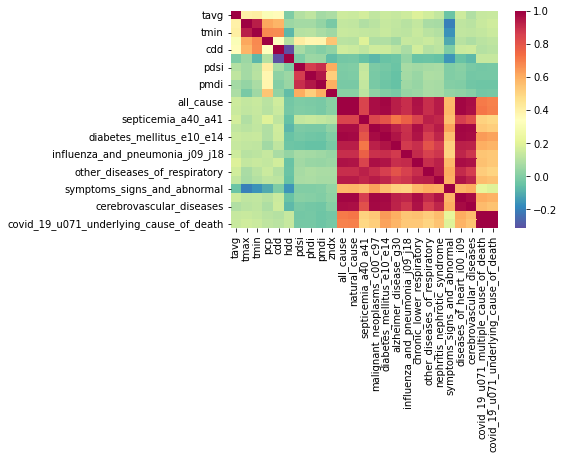

In [ ]:
# look at correlation between variables
num_df.corr()
sns.heatmap(num_df.corr(),cmap="Spectral_r")

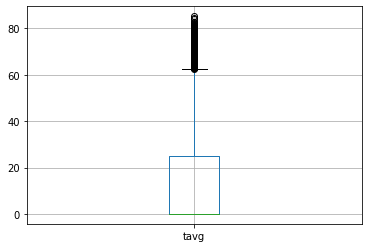

In [ ]:
# explore tavg as independant variable
full_df[["tavg"]].boxplot()

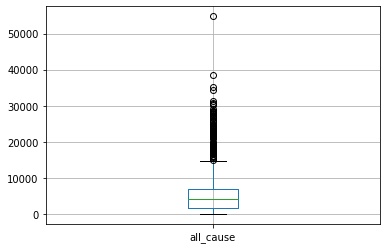

In [ ]:
# explore monthly death count as response variable
full_df[["all_cause"]].boxplot()

Text(0, 0.5, 'monthly deathcount')

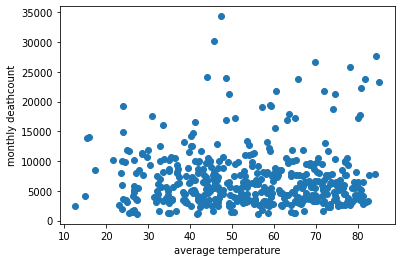

In [ ]:
# create scatter plot of tavg vs all_cause
%matplotlib inline
plt.scatter(x=full_df[full_df['tavg'] >0]["tavg"],y=full_df[full_df['tavg'] >0]["all_cause"] )
#plt.scatter(x=full_df["tavg"],y=full_df["all_cause"] )
plt.xlabel("average temperature")
plt.ylabel("monthly deathcount")

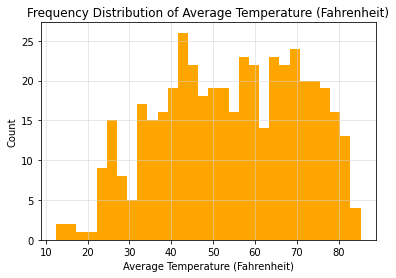

In [18]:
# Histogram of the Average Temperature
plt.hist((full_df[full_df['tavg'] >0]['tavg']), color = 'orange', bins = 30)
#plt.hist(full_df'tavg'], color = 'orange', bins = 30)
plt.title("Frequency Distribution of Average Temperature (Fahrenheit)")
plt.xlabel("Average Temperature (Fahrenheit)")
plt.ylabel("Count")
plt.grid(color = "lightgrey",  linewidth = 0.5)
plt.show()

(array([0.00183402, 0.00183402, 0.00091701, 0.00091701, 0.00825309,
        0.01375516, 0.00733608, 0.00458505, 0.01558918, 0.01375516,
        0.01467217, 0.0174232 , 0.02384227, 0.02017423, 0.01650619,
        0.0174232 , 0.0174232 , 0.01467217, 0.02109124, 0.02017423,
        0.01283815, 0.02109124, 0.02017423, 0.02200825, 0.01834021,
        0.01834021, 0.0174232 , 0.01467217, 0.01192114, 0.00366804]),
 array([12.5       , 14.92333333, 17.34666667, 19.77      , 22.19333333,
        24.61666667, 27.04      , 29.46333333, 31.88666667, 34.31      ,
        36.73333333, 39.15666667, 41.58      , 44.00333333, 46.42666667,
        48.85      , 51.27333333, 53.69666667, 56.12      , 58.54333333,
        60.96666667, 63.39      , 65.81333333, 68.23666667, 70.66      ,
        73.08333333, 75.50666667, 77.93      , 80.35333333, 82.77666667,
        85.2       ]),
 <a list of 30 Patch objects>)

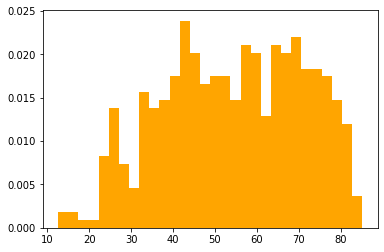

In [23]:
plt.hist((full_df[full_df['tavg'] >0]['tavg']), color = 'orange', bins = 30, density = True)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y, data. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


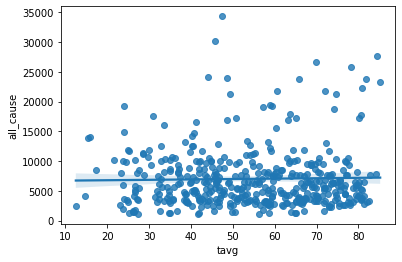

In [ ]:
#Scatter Plot of Average Temperature ~ Monthly Death Counts with SLR

#sns.regplot(full_df['tavg'], full_df['all_cause'], full_df)
sns.regplot(full_df[full_df['tavg'] >0]['tavg'], full_df[full_df['tavg'] >0]['all_cause'], full_df[full_df['tavg'] >0])

In [ ]:
# Provide an overarching interpretation of the data set
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1728 entries, 0 to 1727
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   state                                    1728 non-null   object 
 1   year                                     1728 non-null   object 
 2   month                                    1728 non-null   object 
 3   tavg                                     1728 non-null   float64
 4   tmax                                     1728 non-null   float64
 5   tmin                                     1728 non-null   float64
 6   pcp                                      1728 non-null   float64
 7   cdd                                      1728 non-null   float64
 8   hdd                                      1728 non-null   float64
 9   pdsi                                     1728 non-null   float64
 10  phdi                                     1728 no

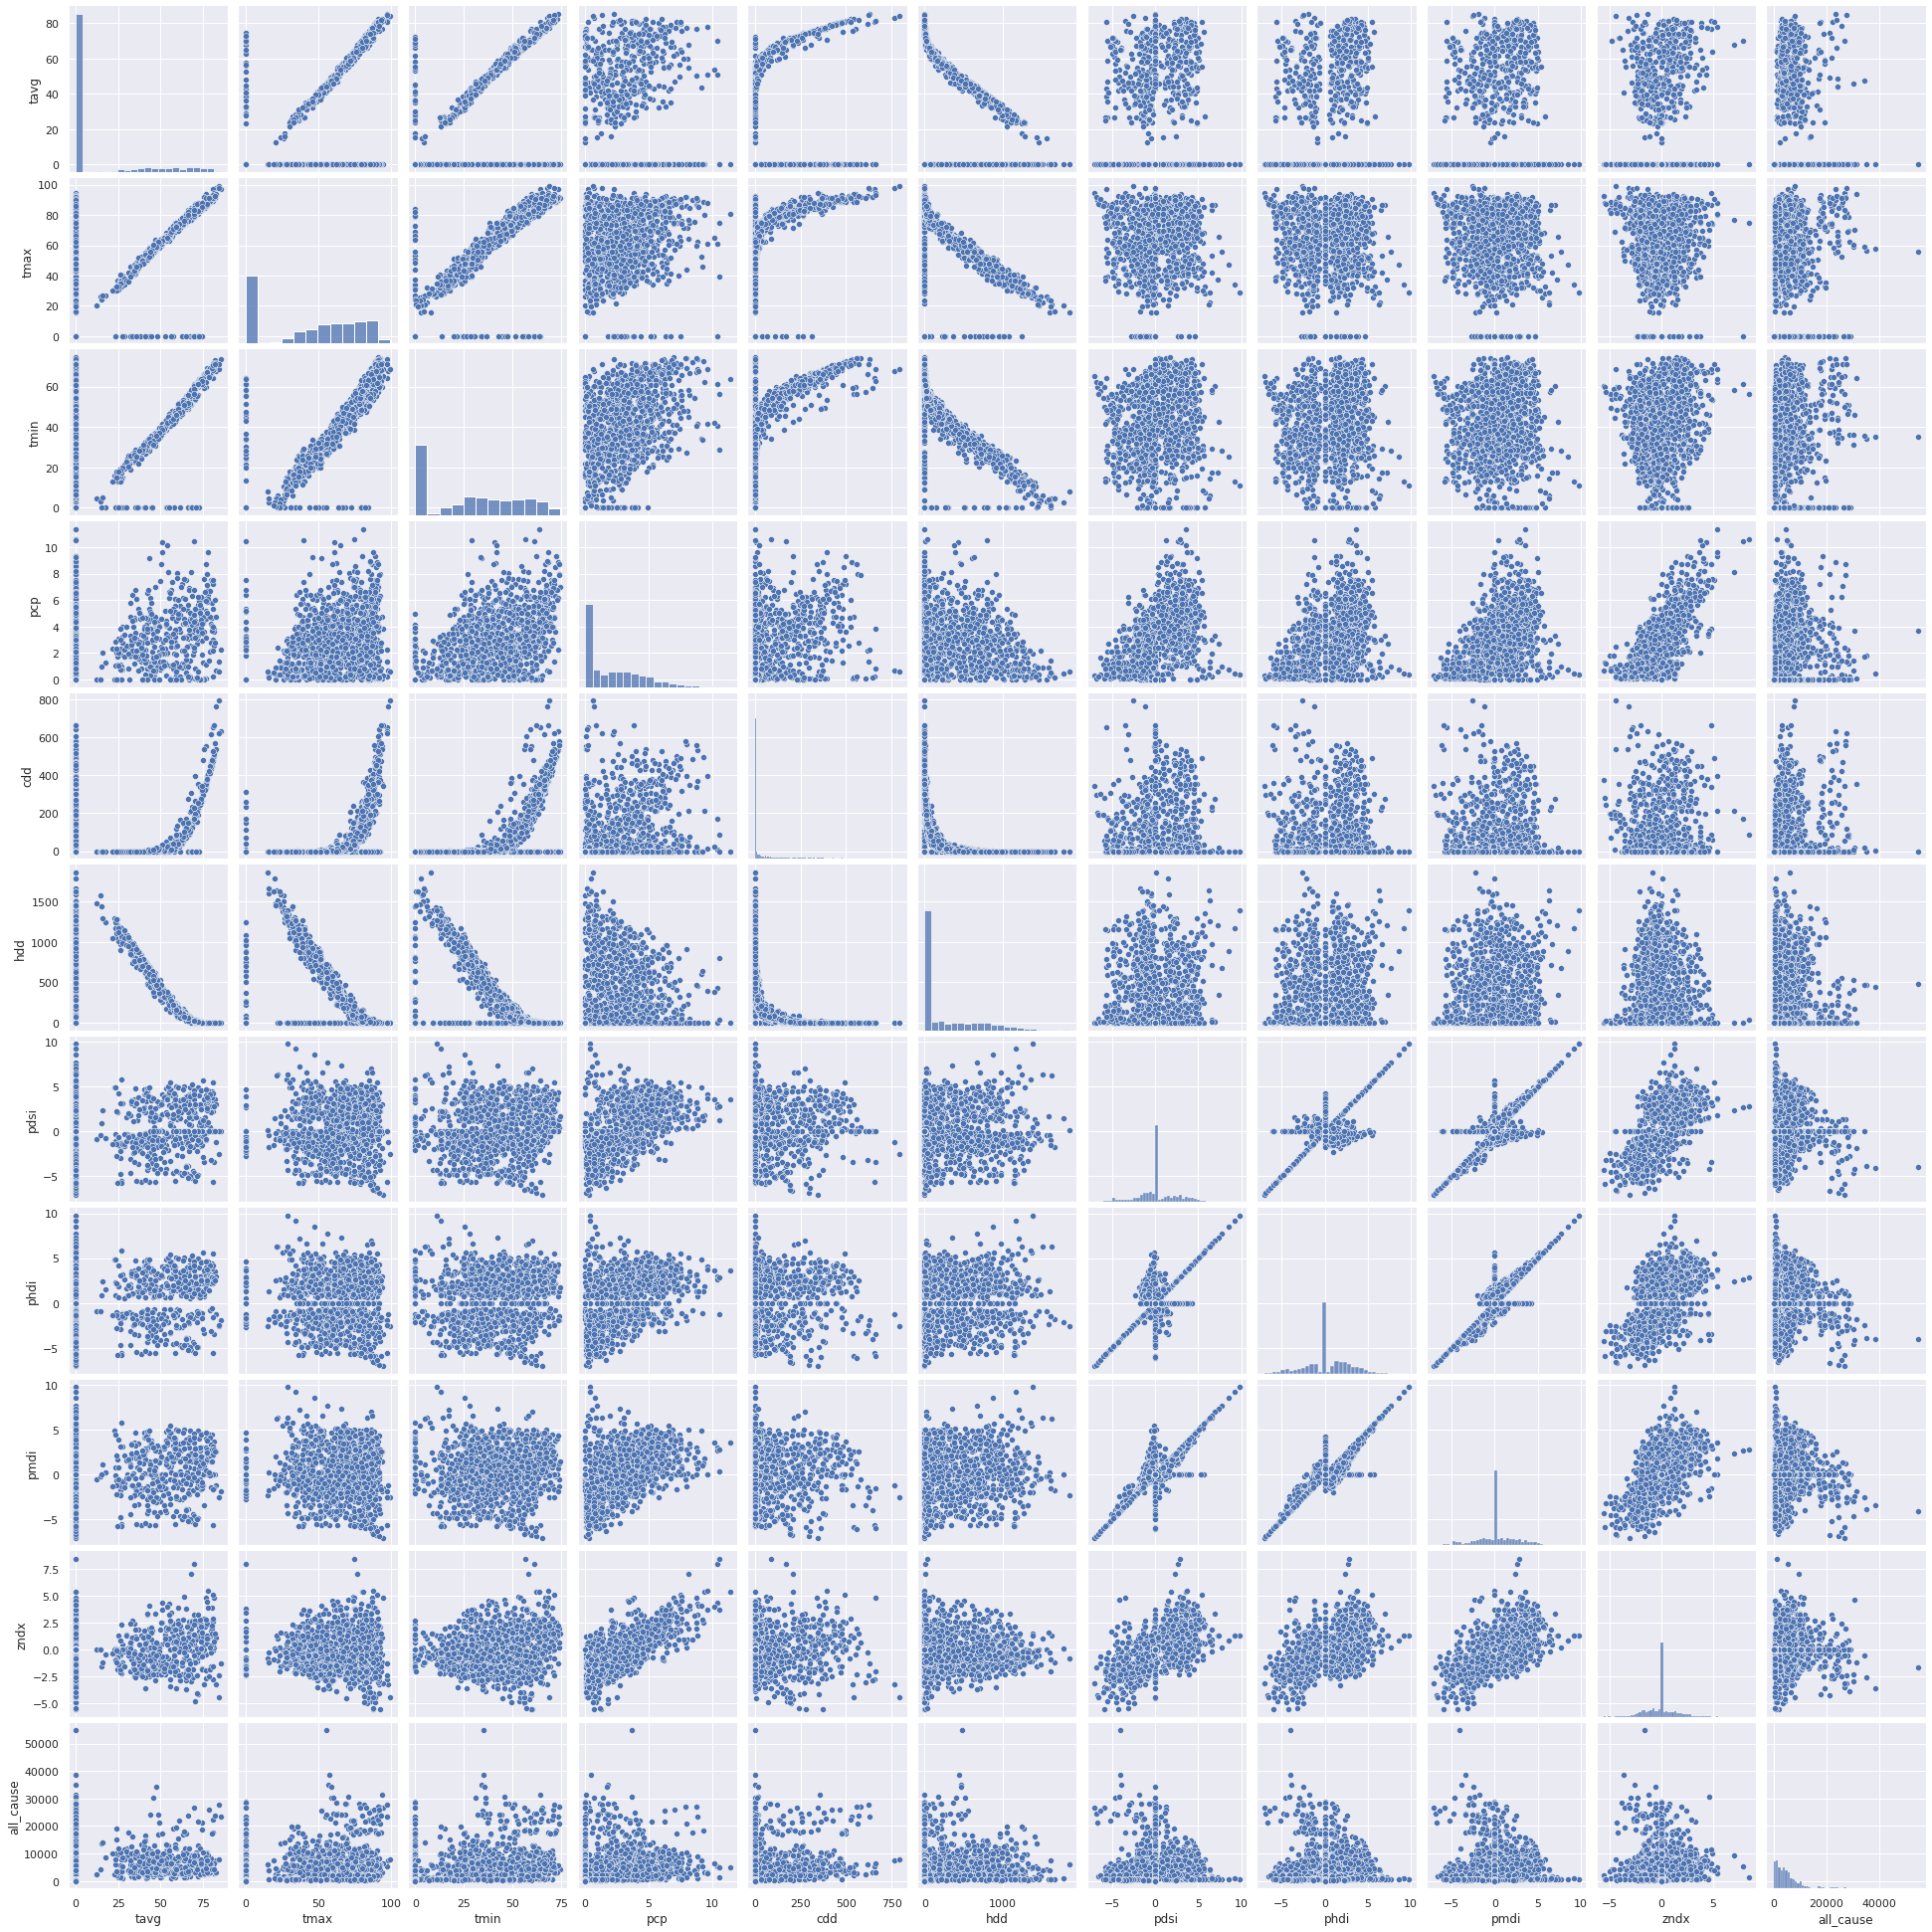

In [ ]:
#scatterplot
sns.set()
subsetdata = full_df.iloc[:,3:14]
sns.pairplot(subsetdata, height = 2.5)
plt.show()

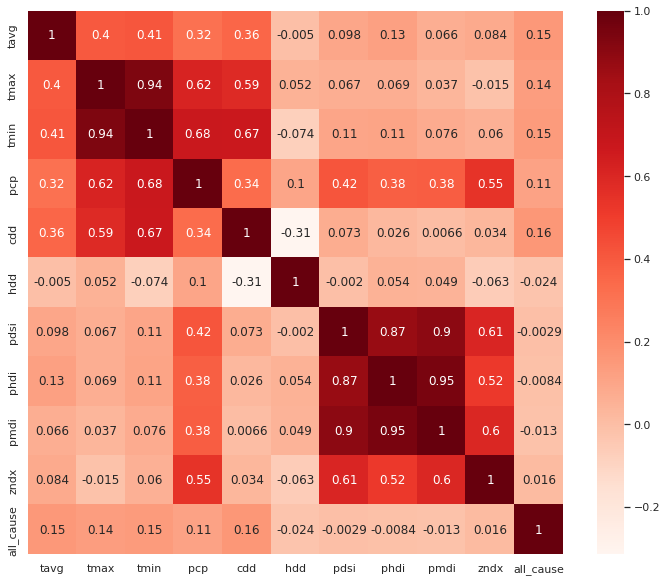

In [ ]:
# Correlation Matrix

plt.figure(figsize=(12,10))
cor = subsetdata.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
# Corrleation 
corr_all_cause = cor["all_cause"].sort_values(ascending=False)
print(corr_all_cause)

all_cause    1.000000
cdd          0.158686
tavg         0.153817
tmin         0.146365
tmax         0.135645
pcp          0.114232
zndx         0.016289
pdsi        -0.002918
phdi        -0.008370
pmdi        -0.013470
hdd         -0.023525
Name: all_cause, dtype: float64


**Interpreation** The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example,the all_cause tends to go up when tavg Spend goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; you can see the pdsi has negative correlation with all_cause. Finally, coefficients close to zero mean that there is no linear correlation.

In [ ]:
# Finding, Removing Outliers using IQR Score
Q1 = full_df.quantile(0.25)
Q3 = full_df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

tavg                                         25.0000
tmax                                         73.8000
tmin                                         49.4250
pcp                                           3.7125
cdd                                          42.0000
hdd                                         512.2500
pdsi                                          2.1050
phdi                                          2.9025
pmdi                                          2.1425
zndx                                          1.2925
all_cause                                  5308.2500
natural_cause                              4868.0000
septicemia_a40_a41                           96.0000
malignant_neoplasms_c00_c97                 949.5000
diabetes_mellitus_e10_e14                   155.2500
alzheimer_disease_g30                       194.5000
influenza_and_pneumonia_j09_j18              93.0000
chronic_lower_respiratory                   239.5000
other_diseases_of_respiratory               10

In [ ]:
# Deleting the outliers
full_df_outl = full_df[~((full_df < (Q1 - 1.5 * IQR)) |(full_df > (Q3 + 1.5 * IQR))).any(axis=1)]
full_df_outl.shape

<ipython-input-37-b5d0d4ab173a>:2: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  full_df_outl = full_df[~((full_df < (Q1 - 1.5 * IQR)) |(full_df > (Q3 + 1.5 * IQR))).any(axis=1)]


(925, 28)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


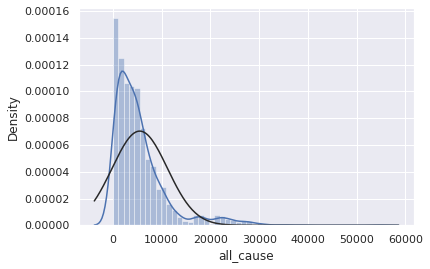

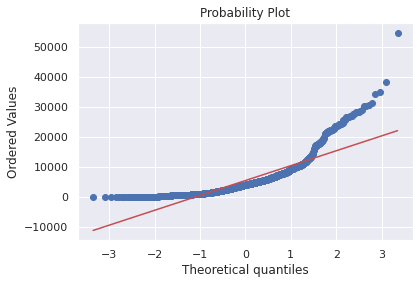

In [ ]:
# Checking the target variable
#Normality
#histogram and normal probability plot
from scipy.stats import norm
from scipy import stats
sns.distplot(full_df['all_cause'], fit=norm);
fig = plt.figure()
res = stats.probplot(full_df['all_cause'], plot=plt)


In [ ]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1728 entries, 0 to 1727
Data columns (total 28 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   state                                    1728 non-null   object 
 1   year                                     1728 non-null   object 
 2   month                                    1728 non-null   object 
 3   tavg                                     1728 non-null   float64
 4   tmax                                     1728 non-null   float64
 5   tmin                                     1728 non-null   float64
 6   pcp                                      1728 non-null   float64
 7   cdd                                      1728 non-null   float64
 8   hdd                                      1728 non-null   float64
 9   pdsi                                     1728 non-null   float64
 10  phdi                                     1728 no

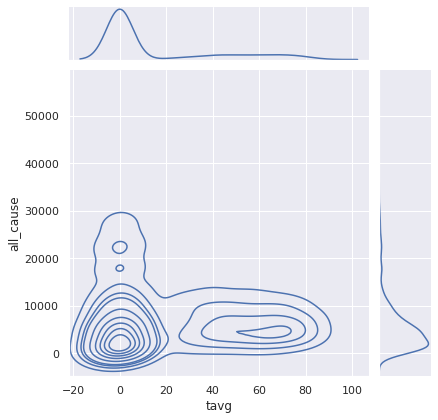

In [ ]:
# Joint Distributions plot
sns.jointplot(
  data = full_df, 
  x = "tavg", y = "all_cause", 
  kind='kde'
)


# Methods

## Linear Regression Model

In [ ]:
# splitting the dataset into  independent variable X and dependent(target) y
X = full_df.iloc[:, 1:13] # the predictor variables from year to zndx
y = full_df.all_cause # the response variable predicting the total death

In [ ]:
X.shape[1] /2 

6.0

In [ ]:
# Variable selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Fit the linear model
model = LinearRegression()
#Initializing RFE model
rfe = RFE(estimator = model, n_features_to_select = int(X.shape[1] / 2)) # normally slect half of the features
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X,y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True False False False  True False False False  True  True  True]
[1 1 2 4 6 1 5 7 3 1 1 1]


In [ ]:
# Pick out the most important features
arr = rfe.support_
index = np.where(arr == 1)
most_inp = X.columns[index]
print(f'The most important features are {most_inp}')

The most important features are Index(['year', 'month', 'pcp', 'phdi', 'pmdi', 'zndx'], dtype='object')


In [ ]:
X.columns

Index(['year', 'month', 'tavg', 'tmax', 'tmin', 'pcp', 'cdd', 'hdd', 'pdsi',
       'phdi', 'pmdi', 'zndx'],
      dtype='object')

**Interpretation** This is the RFE for selecting the most correlated features with target varaible RFE (Recursive Feature Elimination) It then gives the ranking of all the variables, 1 being most important. It also gives its support, True being relevant feature and False being irrelevant feature. 

In [ ]:
# find the optimum number of features
from sklearn.model_selection  import train_test_split
from sklearn.linear_model import LinearRegression

#no of features
nof_list=np.arange(1, 12)            
high_score=0
#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(estimator = model, n_features_to_select = nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print(f"Optimum number of features: {nof}")
print(f"Score with {nof} features: {high_score}")

Optimum number of features: 8
Score with 8 features: 0.05671049358328817


In [ ]:
# Apply back into Linear Regression with 8 feature to get the ranking

# Fit the linear model
model = LinearRegression()
rfe = RFE(estimator = model, n_features_to_select = 8)
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X,y)
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True False False  True False False  True  True  True  True]
[1 1 1 2 4 1 3 5 1 1 1 1]


**Interpretation:** With the outputs above, we will choose 8 most important features as our predictor features, which are 'year', 'month', 'tmin', 'pcp', 'phdi', 'pmdi', 'pdsi', 'zndx'.

In [ ]:
# Pick out the most important features
arr = rfe.support_
index = np.where(arr == 1)
most_imp_df = X.iloc[:, index[0].tolist()]
most_imp_df

,year,month,tavg,pcp,pdsi,phdi,pmdi,zndx
0,2020,01,49.5,7.44,1.70,1.70,1.70,1.89
1,2020,02,51.0,10.37,2.99,2.99,2.99,4.38
2,2020,03,63.5,6.18,2.34,2.34,1.86,-1.02
3,2020,04,62.0,7.10,2.71,2.71,2.71,1.84
4,2020,05,68.9,3.64,2.36,2.36,2.20,-0.22
...,...,...,...,...,...,...,...,...
1723,2022,08,0.0,0.00,0.00,0.00,0.00,0.00
1724,2022,09,0.0,0.00,0.00,0.00,0.00,0.00
1725,2022,10,0.0,0.00,0.00,0.00,0.00,0.00
1726,2022,11,0.0,0.00,0.00,0.00,0.00,0.00


In [ ]:
# Fitting the linear regression model
from sklearn.linear_model import LinearRegression

fitted_model = LinearRegression()
fitted_model.fit(X_train, y_train)

intercept = round(fitted_model.intercept_, 2)
slopes = list(map(lambda x: round(x, 2), fitted_model.coef_))
score = fitted_model.score(X_train, y_train)

print(f'The intercept is {intercept}\n')
print(f'The slopes are {slopes}\n')
print(f'The score is {round(score, 2)}')

The intercept is -1357962.47

The slopes are [674.22, -82.8, 27.75, 6.09, 2.35, 141.92, 5.58, 0.44, -223.55, -125.09, 269.2, -17.06]

The score is 0.05


In [ ]:
# Predicting the Test set results


y_pred = fitted_model.predict(X_test)
print(y_pred)
intercept = round(fitted_model.intercept_, 2)
slopes = list(map(lambda x: round(x, 2), fitted_model.coef_))
score = fitted_model.score(X_test, y_test)

print(f'The intercept is {intercept}\n')
print(f'The slopes are {slopes}\n')
print(f'The score is {round(score, 2)}')

[ 5044.67951288  5713.36798646  5752.75461182  4477.8981773
  5272.99431663  4694.50070273  4974.67087723  4560.69362729
  6333.39095498  6558.4441932   9571.74536043  4923.13387936
  5799.93256723  3951.66492399  5317.74945136  7079.74384993
  4165.67528789  7224.01678397  8295.07496745  6689.91264628
  6066.16377786  4312.30727733  4609.71477948  4726.28452727
  4868.4569921   6740.61421152  6794.7969631   3893.4855924
  5706.07162605  7592.00504854  6371.64440329  4452.20722737
  5715.64294685  5425.30606696  4395.10272732  5945.63032734
  4643.48907728  6265.89958066  4395.10272732  7398.80793669
  4891.87542724  9219.33924348  5723.27422644  5334.0600375
  4633.28730765  4366.33238818  5282.95137444  4395.10272732
  5140.2617772   4477.8981773   4477.8981773   5295.50650963
  5165.72211225  4726.28452727  5118.54579104  5733.74113012
  4395.10272732 11289.47960535  7537.62185877  4550.86226874
  4809.07997725  6001.42360484  6946.48064697  4805.12797937
  5941.38135563  6160.37138

In [ ]:
d = y_test - y_pred
mse = round(np.mean(d**2), 2)
mae = round(np.mean(abs(d)), 2)
rmse = round(np.sqrt(mse), 2)
r2 = round(1-(sum(d**2)/sum((y_test-np.mean(y_test))**2)), 2)

print("Results by manual calculation:")
print(f"MAE: {mae}\n")
print(f"MSE: {mse}\n")
print(f"RMSE: {rmse}\n")
print(f"R-Squared: {r2}")

Results by manual calculation:
MAE: 3672.48

MSE: 27164157.81

RMSE: 5211.92

R-Squared: 0.05


/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


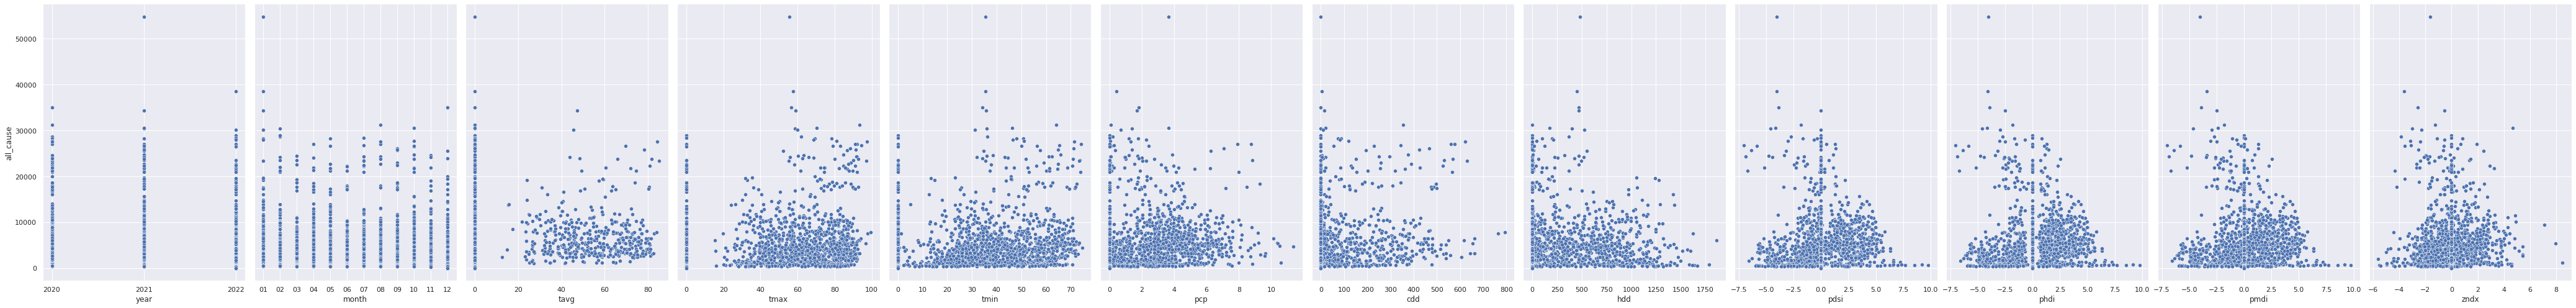

In [ ]:
# Check for Linear relationship/independency bewteen response variable and predictors 
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(full_df, x_vars=X.columns.to_list(), y_vars='all_cause', size=7, aspect=0.7)
plt.show()

By looking at the plots we can see that with the all_cause variable the none of the independent variables form an accurately linear shape but tmax, tmin, cdd, hdd, tavg do still better than the other predictors that seem to hardly have any specific shape. So it shows that a linear regression fitting might not be the best model for it. A linear model might not be able to efficiently explain the data in terms of variability, prediction accuracy etc.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Residuals vs fitted values plot for homoscedasticity check')

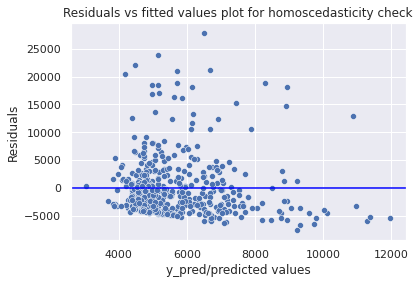

In [ ]:
# Check for homoscedasticity by plotting the residuals against the predicted values
residual = d
p = sns.scatterplot(y_pred, residual)
p.axhline(0, color = "blue")
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.title('Residuals vs fitted values plot for homoscedasticity check')

Homoscedasticity means that the residuals have equal or almost equal variance across the regression line. By plotting the error terms with predicted terms we can that the observations are not evenly distributed in the plot, so which means the residuals does not have constant variance at every level of x.

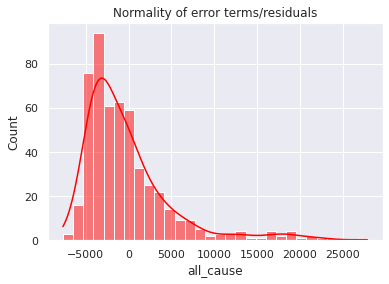

In [ ]:
# Check for normality by plotting a histogram of the residuals
sns.histplot(residual, kde = True, color = "red")
plt.title('Normality of error terms/residuals')
plt.show() 

The residual terms are pretty much normally distributed for the number of test points we took.

## Random Forest Regression Model

In [ ]:
fitted_model

LinearRegression()

In [ ]:
# Fitting the Random Forest regression model
from sklearn.ensemble import RandomForestRegressor
fitted_model = RandomForestRegressor()
fitted_model.fit(X_train, y_train)
score = fitted_model.score(X_train, y_train)
print(f'The score is {round(score, 2)}')


The score is 0.71


In [ ]:
#fitted_model.estimators_

In [ ]:
y_pred = fitted_model.predict(X_test)

score = fitted_model.score(X_test, y_test)

print(f'The score is {round(score, 2)}')

The score is 0.28


In [ ]:
# calculate manually
d = y_test - y_pred
mse = round(np.mean(d**2), 2)
mae = round(np.mean(abs(d)), 2)
rmse = round(np.sqrt(mse), 2)
r2 = round(1-(sum(d**2)/sum((y_test-np.mean(y_test))**2)), 2)

print("Results by manual calculation:")
print(f"MAE: {mae}\n")
print(f"MSE: {mse}\n")
print(f"RMSE: {rmse}\n")
print(f"R-Squared: {r2}")

Results by manual calculation:
MAE: 3178.68

MSE: 20723400.54

RMSE: 4552.3

R-Squared: 0.28


# Gradient Boosting Regression Model

In [ ]:
# Fitting the Gradient Boosting regression model
from sklearn.ensemble import GradientBoostingRegressor
fitted_model = GradientBoostingRegressor()
fitted_model.fit(X_train, y_train)
score = fitted_model.score(X_train, y_train)
print(f'The score is {round(score, 2)}')

The score is 0.56


In [ ]:
y_pred = fitted_model.predict(X_test)

score = fitted_model.score(X_test, y_test)

print(f'The score is {round(score, 2)}')

The score is 0.18


In [ ]:
# calculate manually
d = y_test - y_pred
mse = round(np.mean(d**2), 2)
mae = round(np.mean(abs(d)), 2)
rmse = round(np.sqrt(mse), 2)
r2 = round(1-(sum(d**2)/sum((y_test-np.mean(y_test))**2)), 2)

print("Results by manual calculation:")
print(f"MAE: {mae}\n")
print(f"MSE: {mse}\n")
print(f"RMSE: {rmse}\n")
print(f"R-Squared: {r2}")

Results by manual calculation:
MAE: 3338.97

MSE: 23639617.43

RMSE: 4862.06

R-Squared: 0.18


# Model Comparisons


In [ ]:
full_df.iloc[:,1:]#.to_csv("full_df.csv")
pd.read_csv("https://raw.githubusercontent.com/jortiz71/p4ds/main/full_df%20(1).csv", index_col = 0)

,state,year,month,tavg,tmax,tmin,pcp,cdd,hdd,pdsi,...,alzheimer_disease_g30,influenza_and_pneumonia_j09_j18,chronic_lower_respiratory,other_diseases_of_respiratory,nephritis_nephrotic_syndrome,symptoms_signs_and_abnormal,diseases_of_heart_i00_i09,cerebrovascular_diseases,covid_19_u071_multiple_cause_of_death,covid_19_u071_underlying_cause_of_death
0,Alabama,2020,1,49.5,59.8,39.2,7.44,21.0,524.0,1.70,...,202.0,115.0,292.0,65.0,85.0,106.0,1065.0,264.0,0.0,0.0
1,Alabama,2020,2,51.0,61.2,40.7,10.37,9.0,429.0,2.99,...,262.0,149.0,373.0,92.0,95.0,115.0,1403.0,322.0,0.0,0.0
2,Alabama,2020,3,63.5,73.9,53.2,6.18,90.0,173.0,2.34,...,243.0,116.0,277.0,100.0,87.0,79.0,1037.0,267.0,23.0,20.0
3,Alabama,2020,4,62.0,74.6,49.4,7.10,37.0,155.0,2.71,...,254.0,83.0,247.0,77.0,73.0,84.0,1036.0,257.0,304.0,285.0
4,Alabama,2020,5,68.9,80.8,57.0,3.64,142.0,42.0,2.36,...,264.0,92.0,301.0,83.0,96.0,102.0,1358.0,265.0,478.0,446.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1723,Wyoming,2022,8,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,10.0,0.0,0.0,0.0,79.0,0.0,0.0,0.0
1724,Wyoming,2022,9,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,14.0,0.0,0.0,0.0,81.0,0.0,0.0,0.0
1725,Wyoming,2022,10,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0
1726,Wyoming,2022,11,0.0,0.0,0.0,0.00,0.0,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,22.0,46.0,0.0,0.0,0.0


In [ ]:


model = LinearRegression()
model.fit(X, y)
model.score(X, y)

0.05073233464335303

In [ ]:
len(model.coef_)

12